In [1]:
import json
import datetime
import pytz
import gender_guesser.detector as gender
import pandas as pd
from tzwhere import tzwhere
gender_guesser = gender.Detector(case_sensitive=False)
tzwhere_ = tzwhere.tzwhere()

In [2]:
def check_hashtag(single_tweet):
    '''check whether tweet has any hashtags'''
    return len(single_tweet['entities']['hashtags']) > 0

def check_media(single_tweet):
    '''check whether tweet has any media attached'''
    return len(single_tweet['entities']['media' ]) > 0

def check_url(single_tweet):
    '''check whether tweet has any urls attached'''
    return len(single_tweet['entities']['urls']) > 0

def check_retweet(single_tweet):
    '''
    check whether tweet is a RT. If yes:
    return name & user name of the RT'd user.
    otherwise just return nones
    '''
    if 'retweeted_status' in single_tweet.keys():
        return (single_tweet['retweeted_status']['user']['screen_name'],
                single_tweet['retweeted_status']['user']['name'])
    else:
        return (None,None)
    
def check_coordinates(single_tweet):
    '''
    check whether tweet has coordinates attached.
    if yes return the coordinates
    otherwise just return nones
    '''
    if 'coordinates' in single_tweet['geo'].keys():
        return (single_tweet['geo']['coordinates'][0],
                single_tweet['geo']['coordinates'][1])
    else:
        return (None,None)

def check_reply_to(single_tweet):
    '''
    check whether tweet is a reply. If yes:
    return name & user name of the user that's replied to.
    otherwise just return nones
    '''
    if 'in_reply_to_screen_name' in single_tweet.keys():
        name = None
        for user in single_tweet['entities']['user_mentions']:
            if user['screen_name'] == single_tweet['in_reply_to_screen_name']:
                name = user['name']
                break
        return (single_tweet['in_reply_to_screen_name'],name)
    else:
        return (None,None)

def convert_time(coordinates,time_utc):
    '''
    Does this tweet have a geo location? if yes 
    we can easily convert the UTC timestamp to true local time!
    otherwise return nones
    '''
    if coordinates[0] and coordinates[1]:
        timezone_str = tzwhere_.tzNameAt(coordinates[0],coordinates[1])
        if timezone_str:
            timezone = pytz.timezone(timezone_str)
            time_obj_local = datetime.datetime.astimezone(time_utc,timezone)
            return time_obj_local
    
def create_dataframe(tweets):
    '''
    create a pandas dataframe from our tweet jsons
    '''
    
    # initalize empty lists
    utc_time = []
    longitude = []
    latitude = []
    local_time = []
    hashtag = []
    media = []
    url = []
    retweet_user_name = []
    retweet_name = []
    reply_user_name = []
    reply_name = []
    text = []
    # iterate over all tweets and extract data
    for single_tweet in tweets:
        utc_time.append(datetime.datetime.strptime(single_tweet['created_at'],'%Y-%m-%d %H:%M:%S %z'))
        coordinates = check_coordinates(single_tweet)
        latitude.append(coordinates[0])
        longitude.append(coordinates[1])
        local_time.append(convert_time(coordinates,datetime.datetime.strptime(single_tweet['created_at'],'%Y-%m-%d %H:%M:%S %z')))
        hashtag.append(check_hashtag(single_tweet))
        media.append(check_media(single_tweet))
        url.append(check_url(single_tweet))
        retweet = check_retweet(single_tweet)
        retweet_user_name.append(retweet[0])
        retweet_name.append(retweet[1])
        reply = check_reply_to(single_tweet)
        reply_user_name.append(reply[0])
        reply_name.append(reply[1])
        text.append(single_tweet['text'])
    # convert the whole shebang into a pandas dataframe
    dataframe = pd.DataFrame(data= {
                    'utc_time' : utc_time,
                    'local_time' : local_time,
                    'latitude' : latitude,
                    'longitude' : longitude,
                    'hashtag' : hashtag,
                    'media' : media,
                    'url' : url,
                    'retweet_user_name' : retweet_user_name,
                    'retweet_name' : retweet_name,
                    'reply_user_name' : reply_user_name,
                    'reply_name' : reply_name,
                    'text' : text
    })
    return dataframe

def read_file_index(index_file):
    '''
    read file that lists all 
    tweet-containing json files
    '''
    with open(index_file) as f:    
        d = f.readlines()[1:]
        d = "".join(d)
        d = "[{" + d
        files = json.loads(d)
    return files

def read_single_file(fpath):
    '''
    read in the json of a single tweet.json
    '''
    with open(fpath) as f:
        d = f.readlines()[1:]
        d = "".join(d)
        tweets = json.loads(d)
    return tweets

def read_files(file_list,base_path):
    '''
    use the file list as generated by
    read_file_index() to read in the json
    of all tweet.json files and convert them 
    into individual data frames.
    Returns them so far not concatenated
    '''
    data_frames = []
    for single_file in file_list:
        tweets = read_single_file(base_path + '/' + single_file['file_name'])
        df_tweets = create_dataframe(tweets)
        data_frames.append(df_tweets)
    return data_frames

In [3]:
file_index = read_file_index('twitter_archive/data/js/tweet_index.js')
dataframes = read_files(file_index,'twitter_archive')
dataframe = pd.concat(dataframes)
dataframe.sort_values('utc_time',ascending=False)
dataframe = dataframe.set_index('utc_time')

In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [38]:
dataframe = dataframe.replace(to_replace={'url': {False: None},'hashtag': {False: None},'media': {False: None}})
dataframe_grouped = dataframe.groupby(dataframe.index.date).count()
dataframe_grouped.index = pd.to_datetime(dataframe_grouped.index)
dataframe_mean_week = dataframe_grouped.rolling('365d').mean()
dataframe_mean_week

,hashtag,latitude,local_time,longitude,media,reply_name,reply_user_name,retweet_name,retweet_user_name,text,url
2008-04-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
2008-04-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000,0.000000,7.000000,0.000000
2008-04-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,1.000000,0.000000,0.000000,7.666667,0.000000
2008-04-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,1.000000,0.000000,0.000000,7.250000,0.000000
2008-04-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.800000,0.000000,0.000000,6.400000,0.000000
2008-04-07,0.000000,0.000000,0.000000,0.000000,0.000000,1.166667,1.333333,0.000000,0.000000,7.166667,0.000000
2008-04-08,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.142857,0.000000,0.000000,7.142857,0.000000
2008-04-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.875000,1.000000,0.000000,0.000000,7.000000,0.000000
2008-04-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.777778,1.000000,0.000000,0.000000,7.000000,0.000000
2008-04-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.700000,1.000000,0.000000,0.000000,6.900000,0.000000


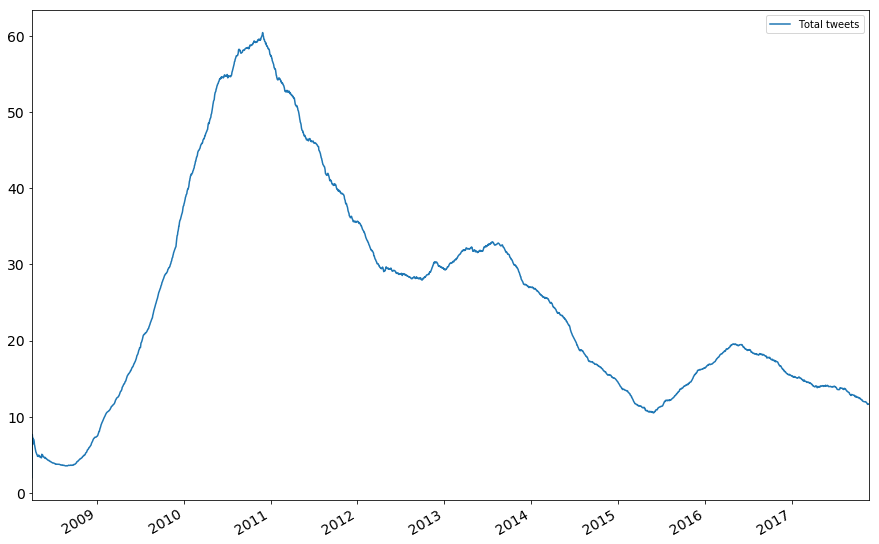

In [6]:
pt = dataframe_mean_week.plot(y=['text'],figsize=(15,10),fontsize=14)
pt.legend(["Total tweets"])

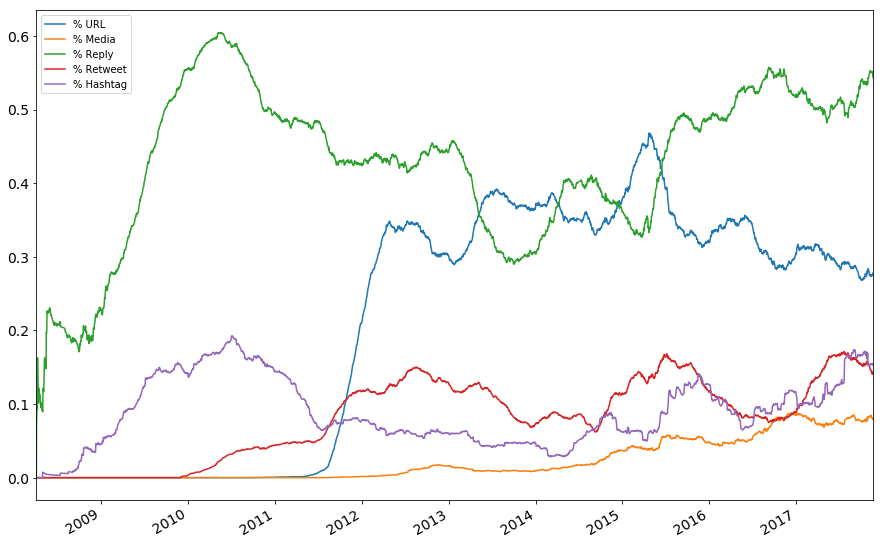

In [7]:
dataframe_mean_week = dataframe_grouped.rolling('180d').mean()
dataframe_mean_week['percent_url'] = dataframe_mean_week['url'] / dataframe_mean_week['text']
dataframe_mean_week['percent_media'] = dataframe_mean_week['media'] / dataframe_mean_week['text']
dataframe_mean_week['percent_reply'] = dataframe_mean_week['reply_name'] / dataframe_mean_week['text']
dataframe_mean_week['percent_retweet'] = dataframe_mean_week['retweet_name'] / dataframe_mean_week['text']
dataframe_mean_week['percent_hashtag'] = dataframe_mean_week['hashtag'] / dataframe_mean_week['text']

dataframe_mean_week = dataframe_mean_week.drop(['reply_user_name',
                                                'retweet_user_name',
                                                'latitude',
                                                'longitude',
                                                'local_time',
                                                'url',
                                                'media',
                                                'reply_name',
                                                'retweet_name',
                                                'hashtag',
                                                #'text',
                                               ],
                                               axis=1)

pt = dataframe_mean_week.plot(y=['percent_url', 'percent_media', 'percent_reply','percent_retweet','percent_hashtag'],figsize=(15,10),fontsize=14)
pt.legend(["% URL", "% Media",'% Reply','% Retweet','% Hashtag'])

df_mean_week_lg = dataframe_mean_week.unstack().reset_index()
df_mean_week_lg.index = pd.to_datetime(df_mean_week_lg['level_1'])

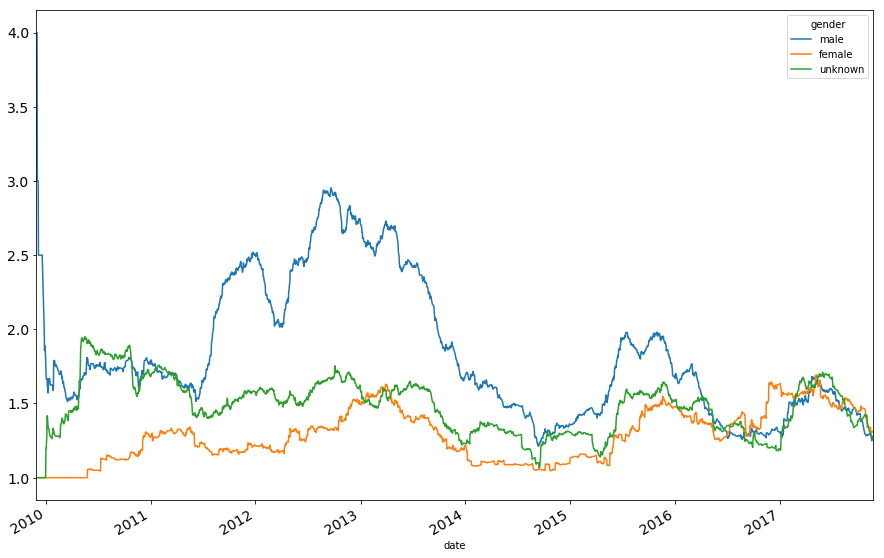

In [8]:
def predict_gender(dataframe,column_name):
    '''
    take full dataframe w/ tweets and extract
    gender for a name-column where applicable
    returns two-column df w/ timestamp & gender
    '''
    splitter = lambda x: x.split()[0]
    gender_column = dataframe.loc[dataframe[column_name].notnull()][column_name].apply(
        splitter).apply(
        gender_guesser.get_gender)

    gender_dataframe = pd.DataFrame(data = {
                    'time' : list(gender_column.index),
                    'gender' : list(gender_column)
                    })
    
    gender_dataframe = gender_dataframe.set_index('time')
    gender_dataframe_tab = gender_dataframe.groupby([gender_dataframe.index.date,gender_dataframe['gender']]).size().reset_index()
    gender_dataframe_tab['date'] = gender_dataframe_tab['level_0']
    gender_dataframe_tab['count'] = gender_dataframe_tab[0]
    gender_dataframe_tab = gender_dataframe_tab.drop([0,'level_0'],axis=1)
    gender_dataframe_tab = gender_dataframe_tab.set_index('date')
    gender_dataframe_tab.index = pd.to_datetime(gender_dataframe_tab.index)
    return gender_dataframe_tab

retweet_gender = predict_gender(dataframe,'retweet_name')
retweet_gender.pivot(columns='gender', values='count').rolling(
    '180d').mean().plot(
    y=['male', 'female','unknown'],figsize=(15,10),fontsize=14)

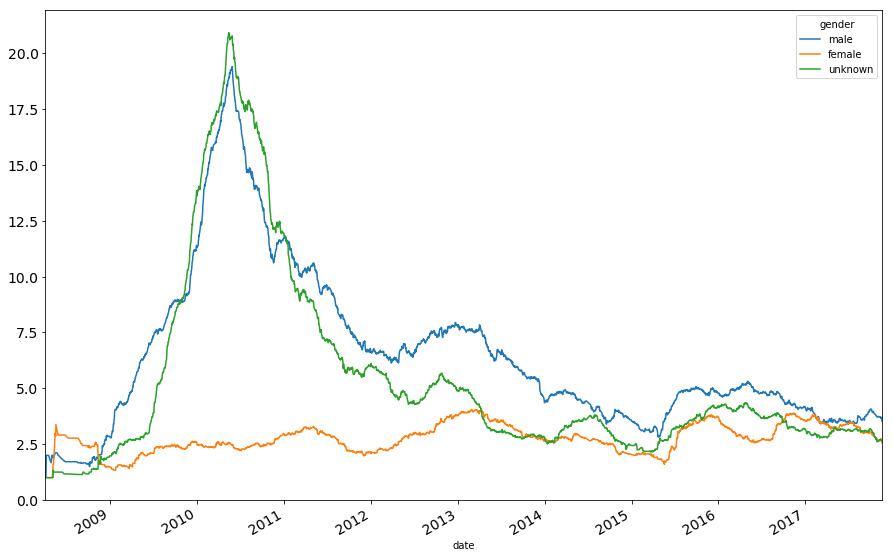

In [9]:
reply_gender = predict_gender(dataframe,'reply_name')
reply_gender.pivot(columns='gender', values='count').rolling(
    '180d').mean().plot(
    y=['male', 'female','unknown'],figsize=(15,10),fontsize=14)

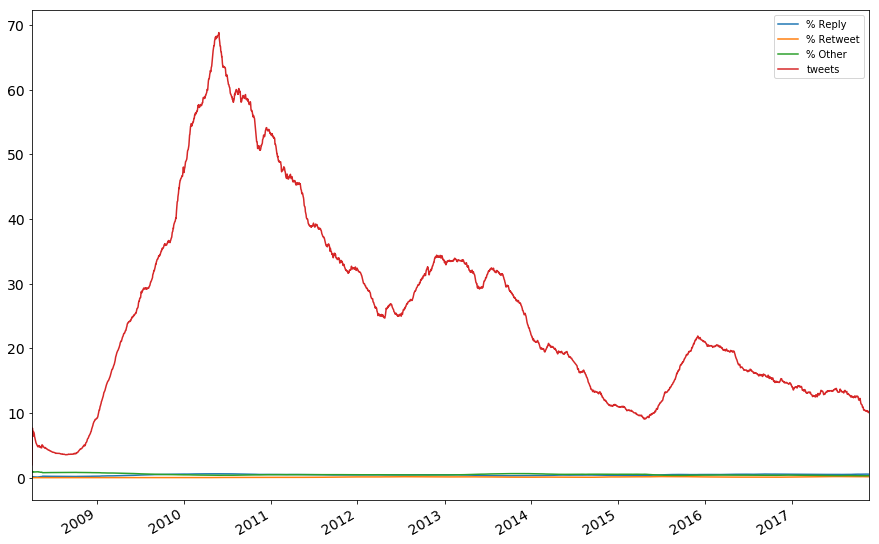

In [47]:
dataframe_mean_week = dataframe_grouped.rolling('180d').mean()
dataframe_mean_week['percent_url'] = dataframe_mean_week['url'] / dataframe_mean_week['text']
dataframe_mean_week['percent_media'] = dataframe_mean_week['media'] / dataframe_mean_week['text']
dataframe_mean_week['percent_reply'] = dataframe_mean_week['reply_name'] / dataframe_mean_week['text']
dataframe_mean_week['percent_retweet'] = dataframe_mean_week['retweet_name'] / dataframe_mean_week['text']
dataframe_mean_week['percent_hashtag'] = dataframe_mean_week['hashtag'] / dataframe_mean_week['text']
dataframe_mean_week['percent_other'] = 1 - (dataframe_mean_week['percent_reply'] + dataframe_mean_week['percent_retweet'])

dataframe_mean_week = dataframe_mean_week.drop(['reply_user_name',
                                                'retweet_user_name',
                                                'latitude',
                                                'longitude',
                                                'local_time',
                                                'url',
                                                'media',
                                                'reply_name',
                                                'retweet_name',
                                                'hashtag',
#                                                'text',
                                               ],
                                               axis=1)

pt = dataframe_mean_week.plot(y=['percent_reply','percent_retweet','percent_other','text'],figsize=(15,10),fontsize=14)
pt.legend(['% Reply','% Retweet','% Other','tweets'])

df_mean_week_lg = dataframe_mean_week.unstack().reset_index()
df_mean_week_lg.index = pd.to_datetime(df_mean_week_lg['level_1'])

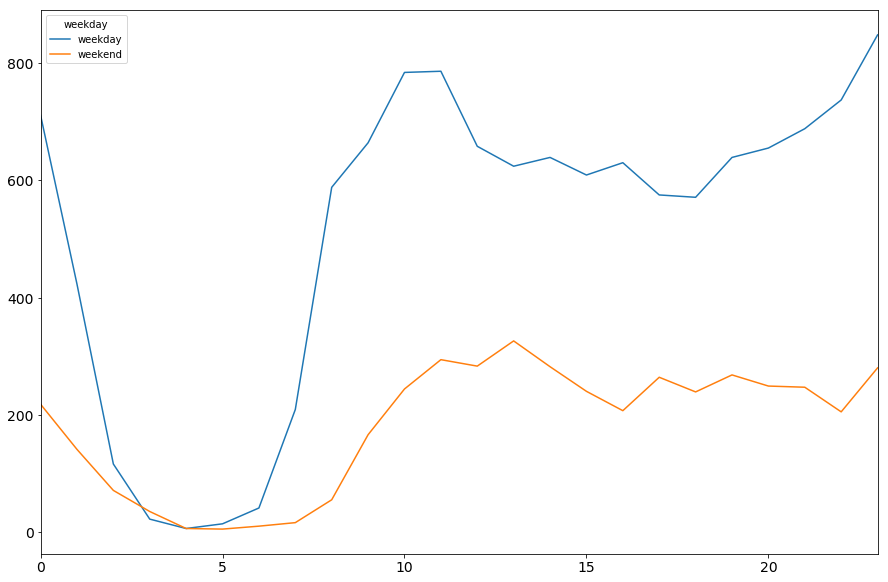

In [16]:
def create_hourly_stats(dataframe):
    get_hour = lambda x: x.hour
    get_weekday = lambda x: x.weekday()

    local_times = dataframe.copy()
    local_times = local_times.loc[dataframe['local_time'].notnull()]

    local_times['weekday'] = local_times['local_time'].apply(get_weekday)
    local_times['hour'] = local_times['local_time'].apply(get_hour)


    local_times = local_times.replace(to_replace={'weekday':
                                                    {0:'weekday',
                                                     1:'weekday',
                                                     2:'weekday',
                                                     3:'weekday',
                                                     4:'weekday',
                                                     5:'weekend',
                                                     6:'weekend',
                                                    }
                                       })

    local_times = local_times.groupby([local_times['hour'],local_times['weekday']]).size().reset_index()
    local_times['values'] = local_times[0]
    local_times = local_times.set_index(local_times['hour'])

    return local_times.pivot(columns='weekday', values='values').reset_index()

local_time = create_hourly_stats(dataframe)
local_time.plot(y=['weekday', 'weekend'],figsize=(15,10),fontsize=14)

In [13]:
# this is the export that metricsgraphicsjs needs!
local_time.to_json(orient='records')

'[{"hour":0,"weekday":711,"weekend":218},{"hour":1,"weekday":423,"weekend":141},{"hour":2,"weekday":116,"weekend":71},{"hour":3,"weekday":22,"weekend":35},{"hour":4,"weekday":6,"weekend":6},{"hour":5,"weekday":14,"weekend":5},{"hour":6,"weekday":41,"weekend":10},{"hour":7,"weekday":209,"weekend":16},{"hour":8,"weekday":588,"weekend":55},{"hour":9,"weekday":664,"weekend":166},{"hour":10,"weekday":784,"weekend":244},{"hour":11,"weekday":786,"weekend":294},{"hour":12,"weekday":658,"weekend":283},{"hour":13,"weekday":624,"weekend":326},{"hour":14,"weekday":639,"weekend":282},{"hour":15,"weekday":609,"weekend":240},{"hour":16,"weekday":630,"weekend":207},{"hour":17,"weekday":575,"weekend":264},{"hour":18,"weekday":571,"weekend":239},{"hour":19,"weekday":639,"weekend":268},{"hour":20,"weekday":655,"weekend":249},{"hour":21,"weekday":688,"weekend":247},{"hour":22,"weekday":737,"weekend":205},{"hour":23,"weekday":848,"weekend":280}]'

In [60]:
dataframe_mean_week = dataframe_grouped.rolling('180d').mean()
dataframe_mean_week['p_url'] = (dataframe_mean_week['url'] / dataframe_mean_week['text']) * 100
dataframe_mean_week['p_media'] = (dataframe_mean_week['media'] / dataframe_mean_week['text']) * 100
dataframe_mean_week['p_reply'] = (dataframe_mean_week['reply_name'] / dataframe_mean_week['text']) * 100
dataframe_mean_week['p_rt'] = (dataframe_mean_week['retweet_name'] / dataframe_mean_week['text']) * 100
dataframe_mean_week['p_hash'] = (dataframe_mean_week['hashtag'] / dataframe_mean_week['text']) * 100
dataframe_mean_week['p_other'] = 100 - (dataframe_mean_week['p_reply'] + dataframe_mean_week['p_rt'])

dataframe_mean_week = dataframe_mean_week.reset_index()
dataframe_mean_week['date'] = dataframe_mean_week['index'].astype(str)
dataframe_mean_week = dataframe_mean_week.drop(['reply_user_name',
                                                'retweet_user_name',
                                                'latitude',
                                                'longitude',
                                                'local_time',
                                                'url',
                                                'media',
                                                'reply_name',
                                                'retweet_name',
                                                'hashtag',
                                                'index',
                                               ],
                                               axis=1)

dataframe_mean_week.to_json(orient='records', double_precision=2)

'[{"text":2.0,"p_url":0.0,"p_media":0.0,"p_reply":0.0,"p_rt":0.0,"p_hash":0.0,"p_other":100.0,"date":"2008-04-02"},{"text":7.0,"p_url":0.0,"p_media":0.0,"p_reply":7.14,"p_rt":0.0,"p_hash":0.0,"p_other":92.86,"date":"2008-04-03"},{"text":7.67,"p_url":0.0,"p_media":0.0,"p_reply":8.7,"p_rt":0.0,"p_hash":0.0,"p_other":91.3,"date":"2008-04-04"},{"text":7.25,"p_url":0.0,"p_media":0.0,"p_reply":10.34,"p_rt":0.0,"p_hash":0.0,"p_other":89.66,"date":"2008-04-05"},{"text":6.4,"p_url":0.0,"p_media":0.0,"p_reply":9.37,"p_rt":0.0,"p_hash":0.0,"p_other":90.62,"date":"2008-04-06"},{"text":7.17,"p_url":0.0,"p_media":0.0,"p_reply":16.28,"p_rt":0.0,"p_hash":0.0,"p_other":83.72,"date":"2008-04-07"},{"text":7.14,"p_url":0.0,"p_media":0.0,"p_reply":14.0,"p_rt":0.0,"p_hash":0.0,"p_other":86.0,"date":"2008-04-08"},{"text":7.0,"p_url":0.0,"p_media":0.0,"p_reply":12.5,"p_rt":0.0,"p_hash":0.0,"p_other":87.5,"date":"2008-04-09"},{"text":7.0,"p_url":0.0,"p_media":0.0,"p_reply":11.11,"p_rt":0.0,"p_hash":0.0,"p_othe

In [64]:
dataframe_mean_week

,text,p_url,p_media,p_reply,p_rt,p_hash,p_other,date
0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,2008-04-02
1,7.000000,0.000000,0.000000,7.142857,0.000000,0.000000,92.857143,2008-04-03
2,7.666667,0.000000,0.000000,8.695652,0.000000,0.000000,91.304348,2008-04-04
3,7.250000,0.000000,0.000000,10.344828,0.000000,0.000000,89.655172,2008-04-05
4,6.400000,0.000000,0.000000,9.375000,0.000000,0.000000,90.625000,2008-04-06
5,7.166667,0.000000,0.000000,16.279070,0.000000,0.000000,83.720930,2008-04-07
6,7.142857,0.000000,0.000000,14.000000,0.000000,0.000000,86.000000,2008-04-08
7,7.000000,0.000000,0.000000,12.500000,0.000000,0.000000,87.500000,2008-04-09
8,7.000000,0.000000,0.000000,11.111111,0.000000,0.000000,88.888889,2008-04-10
9,6.900000,0.000000,0.000000,10.144928,0.000000,0.000000,89.855072,2008-04-11


In [63]:
float(int(9.7))

9.0